In [40]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [41]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [42]:
NUM_CLASSES = 3

# Dataset reading

In [43]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [44]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [46]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [47]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                860       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1,103
Trainable params: 1,103
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [49]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [50]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/19 [>.............................] - ETA: 4s - loss: 1.0930 - accuracy: 0.4062
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
19/19 [==============================] - 0s 7ms/step - loss: 0.9874 - accuracy: 0.5269 - val_loss: 0.8021 - val_accuracy: 0.7995
Epoch 2/1000
 1/19 [>.............................] - ETA: 0s - loss: 0.8780 - accuracy: 0.6328
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
19/19 [==============================] - 0s 3ms/step - loss: 0.7851 - accuracy: 0.6949 - val_loss: 0.6045 - val_accuracy: 0.7995
Epoch 3/1000
 1/19 [>.............................] - ETA: 0s - loss: 0.7081 - accuracy: 0.7422
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
19/19 [==============================] - 0s 3ms/step - loss: 0.6213 - accuracy: 0.7845 - val_loss: 0.4502 - val_accuracy: 0.7995
Epoch 4/1000
 1/19 [>.............................] - ETA: 0s - loss: 0.5376 - accuracy: 0.8359
E

In [51]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

7/7 [==============================] - 0s 1ms/step - loss: 4.8315e-07 - accuracy: 1.0000


In [52]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [53]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[1.0000000e+00 1.9148920e-09 1.0957907e-08]
0


# Confusion matrix

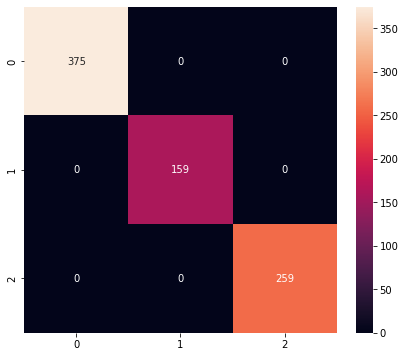

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       375
           1       1.00      1.00      1.00       159
           2       1.00      1.00      1.00       259

    accuracy                           1.00       793
   macro avg       1.00      1.00      1.00       793
weighted avg       1.00      1.00      1.00       793



In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [55]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [56]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/km/k1t_66r11l9b1dgwdbhqdh880000gn/T/tmpbh4zcnty/assets


INFO:tensorflow:Assets written to: /var/folders/km/k1t_66r11l9b1dgwdbhqdh880000gn/T/tmpbh4zcnty/assets
2022-03-28 12:05:01.062164: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-03-28 12:05:01.062186: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-03-28 12:05:01.062330: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/km/k1t_66r11l9b1dgwdbhqdh880000gn/T/tmpbh4zcnty
2022-03-28 12:05:01.064282: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-03-28 12:05:01.064305: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/km/k1t_66r11l9b1dgwdbhqdh880000gn/T/tmpbh4zcnty
2022-03-28 12:05:01.072063: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-03-28 12:05:01.123951: I tensorflow/cc/saved_model/loader.cc:212] Running initialization

6384

# Inference test

In [57]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [58]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [59]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [60]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 107 µs, sys: 59 µs, total: 166 µs
Wall time: 129 µs


In [61]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.0000000e+00 1.9148920e-09 1.0957907e-08]
0
